In [200]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [201]:
def get_exp_config(experiment: Path):
    with open(experiment / "config.json", "r") as f:
        config = json.load(f)
    return config

def get_exp_stats(experiment: Path):
    return pd.read_csv(experiment / "stats.csv")


def get_best_checkpoint(experiment: Path):
    return tf.train.latest_checkpoint(experiment / "best_checkpoints")


In [202]:
EXPDIR = Path("../experiments")

EXPERIMENTS_PATH = EXPDIR / "simple_ppo_envs_comparison"

EXPERIMENTS = list(EXPERIMENTS_PATH.iterdir())

In [203]:
def expanded_stats(experiment: Path):
    stats_df = get_exp_stats(experiment)
    exp_data = get_exp_config(experiment)["experiment"]
    stats_df["env_id"] = exp_data["env_id"]
    return stats_df

In [204]:
stats = pd.concat([expanded_stats(e) for e in EXPERIMENTS])

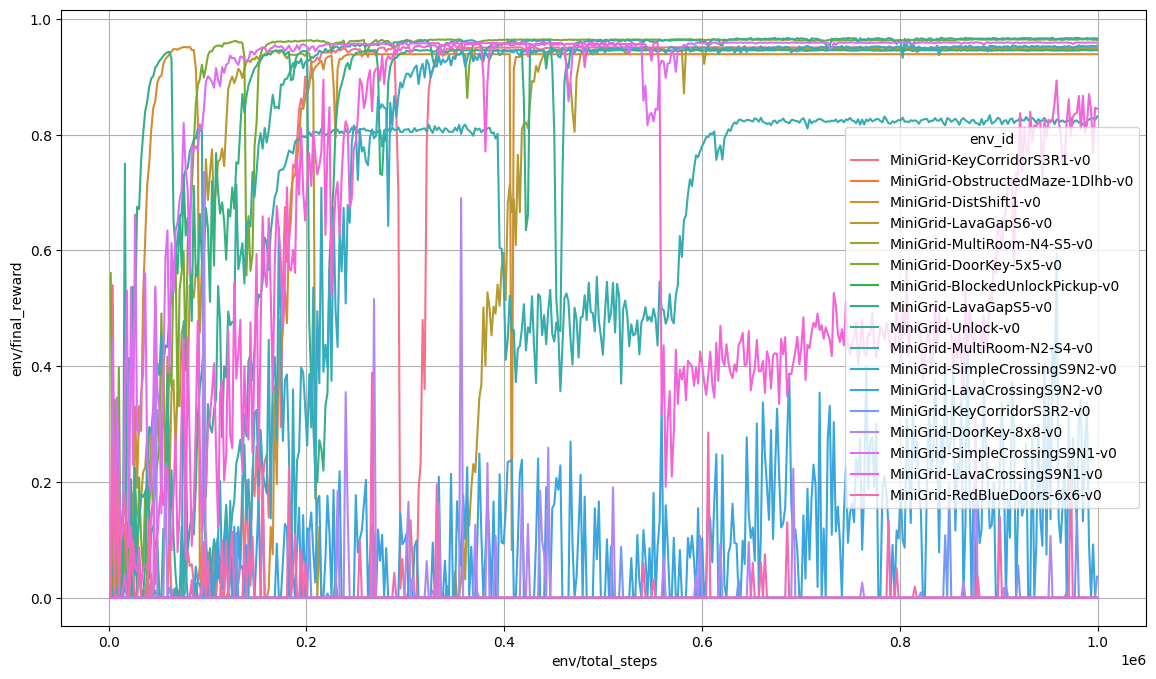

In [205]:
plt.figure(figsize=(14, 8))
sns.lineplot(stats, x="env/total_steps", y="env/final_reward", hue="env_id")
plt.grid()

In [158]:
q98 = stats.groupby("env_id")["env/final_reward"].quantile(0.98)

In [159]:
q98

env_id
MiniGrid-BlockedUnlockPickup-v0     0.000000
MiniGrid-DistShift1-v0              0.946488
MiniGrid-DoorKey-5x5-v0             0.965168
MiniGrid-DoorKey-8x8-v0             0.198842
MiniGrid-KeyCorridorS3R1-v0         0.951321
MiniGrid-KeyCorridorS3R2-v0         0.018645
MiniGrid-LavaCrossingS9N1-v0        0.957509
MiniGrid-LavaCrossingS9N2-v0        0.374044
MiniGrid-LavaGapS5-v0               0.946701
MiniGrid-LavaGapS6-v0               0.948928
MiniGrid-MultiRoom-N2-S4-v0         0.829214
MiniGrid-MultiRoom-N4-S5-v0         0.000000
MiniGrid-ObstructedMaze-1Dlhb-v0    0.000000
MiniGrid-RedBlueDoors-6x6-v0        0.136566
MiniGrid-SimpleCrossingS9N1-v0      0.959787
MiniGrid-SimpleCrossingS9N2-v0      0.953741
MiniGrid-Unlock-v0                  0.967429
Name: env/final_reward, dtype: float64

In [192]:
SOLVED_ITER_REWARD_THRESHOLD = 0.95

# This value is setup given the current analysed runs... It's been
#  visually determined with the training curves which environments
#  has been solved, so in case of repeating the experiments it
#  may be changed, there is no guarantee of generality
SOLVED_Q98_COEF = 0.78

def get_solved_stats(df):
    q98 = df["env/final_reward"].quantile(0.98)

    if q98 < SOLVED_Q98_COEF:
        return pd.Series(
            {"solved": False, "solved_iter": -1, "solved_steps": -1, "q98_final_reward": q98, "solved_reward": float("nan")}
    )
    solved_reward = SOLVED_ITER_REWARD_THRESHOLD * df["env/final_reward"].max()
    solved_flags = df["env/final_reward"] > solved_reward
    solved_iter = solved_flags.idxmax()
    solved_steps = df.loc[solved_iter, "env/total_steps"]
    return pd.Series(
        {"solved": True, "solved_iter": solved_iter, "solved_steps": solved_steps, "q98_final_reward": q98, "solved_reward": solved_reward}
    )


In [193]:
solved_stats = stats.groupby("env_id").apply(get_solved_stats, include_groups=False)

In [194]:
solved_stats

,solved,solved_iter,solved_steps,q98_final_reward,solved_reward
env_id,,,,,
MiniGrid-BlockedUnlockPickup-v0,False,-1,-1,0.000000,NaN
MiniGrid-DistShift1-v0,True,26,55312,0.946488,0.904483
MiniGrid-DoorKey-5x5-v0,True,45,94224,0.965168,0.917222
MiniGrid-DoorKey-8x8-v0,False,-1,-1,0.198842,NaN
MiniGrid-KeyCorridorS3R1-v0,True,99,204816,0.951321,0.903917
MiniGrid-KeyCorridorS3R2-v0,False,-1,-1,0.018645,NaN
MiniGrid-LavaCrossingS9N1-v0,True,128,264208,0.957509,0.911323
MiniGrid-LavaCrossingS9N2-v0,False,-1,-1,0.374044,NaN
MiniGrid-LavaGapS5-v0,True,21,45072,0.946701,0.899960
